Created by Enric Trillo

[GitHub](https://github.com/enrict/)
[Twitter](https://twitter.com/reekz2x)

# Fruit/Veg Image Classification

- This project aims to show how to use the deep learning techniques to develop an image classification algorithm to classify 131 classes. The solution of this problem would be able to be applied in an object detection system aiming to recognise fruits and vegetables. 

- As the project was developed with the use of a Kaggle API token file, you will have to unzip the dataset provided from the first unhashed cell below.

## 1.Importing Data

*   The dataset will be imported by using a Kaggle API token, which allows the download process of the dataset to be done via this notebook without having to leave the page for the most part. As of 09/06/2020, the total number of the dataset is ###, with ### between the Train and Test directories of the dataset.



In [ ]:
#from google.colab import files
#files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"victoriamcleod","key":"1532dca46e23909967b5d990462fc0d1"}'}

In [ ]:
# modifying the permission of the kaggle file | Uncomment below to set up data
#!mkdir -p ~/.kaggle
#!cp kaggle.json ~/.kaggle/

#!chmod 600 ~/.kaggle/kaggle.json
#print('[INFO] API token permission modified!')

[INFO] API token permission modified!


In [ ]:
# downloading the dataset
#!kaggle datasets download -d moltean/fruits
#print('[INFO] dataset downloaded!')

 99% 753M/760M [00:08<00:00, 76.2MB/s]
100% 760M/760M [00:08<00:00, 93.1MB/s]
[INFO] dataset downloaded!


In [ ]:
# extracting the contents of the zipped dataset from the kaggle source
!unzip -q fruits.zip
print('[INFO] dataset unzipped!')

[INFO] dataset unzipped!


## 2.Importing Packages

* The required packages for this project are being imported into the notebook, which will allow the project to operate as intended.

In [ ]:
#Importing required packages
from keras import * # importing everything from keras (mainly for the Keras models, layers etc...)
from keras.applications.vgg19 import VGG19, preprocess_input # importing the pretrained model
import datetime # to calculate the training duration
import os # to operate with the file system of the project
import pandas as pd # to be used along the confusion matrix
import seaborn as sn # to be used along the confusion matrix
from imutils import paths # to operate with the path structure of the project
import matplotlib.pyplot as plt # to plot the results over the given training duration
from sklearn.metrics import confusion_matrix, classification_report # to produce a confusion matrix 
from keras.preprocessing.image import ImageDataGenerator # to preprocess the image data before feeding it into the model
from numpy import argmax # to return the indices in max element in an array (used in the confusion matrix)

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


##3.Project Structure


* Setting up the structure of the project by locating the specific directories for Train and Test data. 

In [ ]:
# locating the training directory 
train_path = '/content/fruits-360/Training'

# locating the testing directory 
test_path = '/content/fruits-360/Test'

use_label_file = False  # this will be set to true if the label names from a file are to be loaded; it uses the label_file defined below; the file should contain the names of the used labels on a separate line
label_file = 'labels.txt'
output_dir = 'output_files'

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

if use_label_file:
    with open(label_file, "r") as f:
        labels = [x.strip() for x in f.readlines()]
else:
    labels = os.listdir(train_path)
num_classes = len(labels)

print(labels)
len(labels)

['Tomato Maroon', 'Raspberry', 'Grape Blue', 'Hazelnut', 'Tomato not Ripened', 'Pineapple Mini', 'Banana Red', 'Tomato 1', 'Peach Flat', 'Pear Monster', 'Tomato Cherry Red', 'Tangelo', 'Physalis with Husk', 'Clementine', 'Potato Red', 'Potato Sweet', 'Apple Red 1', 'Cactus fruit', 'Apple Pink Lady', 'Kumquats', 'Apple Red 3', 'Eggplant', 'Mangostan', 'Apple Golden 3', 'Avocado', 'Grape Pink', 'Lychee', 'Grapefruit White', 'Tomato 3', 'Nut Pecan', 'Cherry 1', 'Cherry Wax Red', 'Pineapple', 'Pear', 'Cherry 2', 'Avocado ripe', 'Lemon', 'Granadilla', 'Limes', 'Quince', 'Potato Red Washed', 'Mulberry', 'Papaya', 'Banana', 'Pepper Red', 'Plum 2', 'Apple Granny Smith', 'Grape White 3', 'Redcurrant', 'Tamarillo', 'Pear Forelle', 'Cherry Rainier', 'Pear Kaiser', 'Apple Red 2', 'Cantaloupe 2', 'Ginger Root', 'Grapefruit Pink', 'Fig', 'Banana Lady Finger', 'Apricot', 'Pomelo Sweetie', 'Nut Forest', 'Huckleberry', 'Apple Red Delicious', 'Corn', 'Blueberry', 'Peach', 'Apple Braeburn', 'Melon Piel d

131

##4.Sample Checking

* Sample checking the directories to verify that the number of samples in each directory match to those in the dataset in Kaggle.

In [ ]:
# directories
totalTrain = len(list(paths.list_images(train_path)))
totalTest = len(list(paths.list_images(test_path)))
total = totalTrain + totalTest

# output
print("[INFO] There are "+str(totalTrain)+ " samples in the Train path")
print("[INFO] There are "+str(totalTest)+ " samples in the Test path")
print("[INFO] There are a total of "+str(total)+ " samples")

[INFO] There are 67692 samples in the Train path
[INFO] There are 22688 samples in the Test path
[INFO] There are a total of 90380 samples


##5.Global Parameters and Functions

* Setting up the global parameters and functions that will be used in/around the network. These include:

  - Number of epochs, optimizer, batch size and image dimensions
  - Augmentation function (Preprocessing images)
  - Data Generator function
  - Confusion Matrix function

The slow optimizer will aid the model in gradual learning during the classifier training phase, as it prevents the weights from the convolutional based from being crushed due to a high learning rate and allowing them to assimilate to the dataset used in this project. 

###Global Parameters

In [ ]:
# setting global parameters for easier modification
print("[INFO] Setting up goblal parameters...")
image_size = 100
batch_size = 128
frozen_epochs = 40
trained_epochs = 2
opt = optimizers.Adam(lr=1e-5)

[INFO] Setting up goblal parameters...


###Functions

In [ ]:
# a function which changes the hue and saturation 
#def augmentation(x):
#    import tensorflow as tf
#    x = tf.image.random_saturation(x, 0.9, 1.2)
#    x = tf.image.random_hue(x, 0.02)
#    return x
#print("[INFO] generating augmentation function...")

[INFO] generating augmentation function...


In [ ]:
# a function which generates the data generators for TVT
print("[INFO] building data generators...\n")

def build_data_generators(train_folder, test_folder, validation_percent, labels=None, image_size=(image_size, image_size), batch_size=batch_size):
    train_datagen = ImageDataGenerator(
        rescale=1./255, #pixel rescaling
        width_shift_range=0.1, # randomly width shift up to 0.1
        height_shift_range=0.1, # randomly height shift up to 0.1
        zoom_range=0.2, # randomly zoom images up to 0.2
        horizontal_flip=True, # randomly flip images horizontally
        vertical_flip=True,  # randomly flip images vertically
        validation_split=validation_percent) # validation set 
    
    test_datagen = ImageDataGenerator(rescale=1./255)

    train_gen = train_datagen.flow_from_directory(
        train_folder, 
        target_size=(image_size, image_size), 
        class_mode='sparse',
        batch_size=batch_size, 
        shuffle=True, 
        subset='training', 
        classes=labels)
    
    val_gen = train_datagen.flow_from_directory(
        train_folder, 
        target_size=(image_size, image_size), 
        class_mode='sparse',
        batch_size=batch_size, 
        shuffle=False, 
        subset='validation', 
        classes=labels)
    
    test_gen = test_datagen.flow_from_directory(
        test_folder, 
        target_size=(image_size, image_size), 
        class_mode='sparse',
        batch_size=batch_size, 
        shuffle=False, 
        subset=None, 
        classes=labels)
  
    
    return train_gen, val_gen, test_gen

[INFO] building data generators...



In [ ]:
# a function to plot the confusion matrix
def plot_confusion_matrix(y_true, y_pred, classes, out_path=""):
    cm = confusion_matrix(y_true, y_pred)
    df_cm = pd.DataFrame(cm, index=[i for i in classes], columns=[i for i in classes])
    plt.figure(figsize=(40, 40))
    ax = sn.heatmap(df_cm, annot=True, square=True, fmt="d", linewidths=.2, cbar_kws={"shrink": 0.8})
    if out_path:
        plt.savefig(out_path)  # saving the matrix as a file in the output directory
    return ax

In [ ]:
# initialising the generators
print("[INFO] initialising data generators...")

train_gen, val_gen, test_gen = build_data_generators(
    train_path, 
    test_path, 
    validation_percent=0.3, 
    labels=labels, 
    image_size=image_size, 
    batch_size=batch_size)

[INFO] initialising data generators...
Found 47427 images belonging to 131 classes.
Found 20265 images belonging to 131 classes.
Found 22688 images belonging to 131 classes.


##6.Model Creation (Classifier)

* Here, the model is being put together. This model will consist of a pretrained model as the base whihch will be frozen to solely train the classifier. This is because the pretrained model already has its own weights and training them on new data with a custom classifier will destroy the weights that the base model was trained on. 

### Model Structure

In [ ]:
# loading the Xception network, ensuring the head layer sets are left off
conv_base = VGG19(weights='imagenet',
                  include_top=False,
                  input_shape=(image_size, image_size, 3))

80142336/80134624 [==============================] - 2s 0us/step


In [ ]:
len(conv_base.layers)

22

In [ ]:
# checking the Xception structure
conv_base.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100, 100, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 100, 100, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 100, 100, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 50, 50, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 50, 50, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 50, 50, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 25, 25, 128)       0     

In [ ]:
# creating the model
model = models.Sequential()

# adding the VGG16 conv base to the model
model.add(conv_base)
model.add(layers.Dropout(0.4))
model.add(layers.Flatten())  # this converts our 3D feature maps to 1D feature vectors
model.add(layers.Dense(256, activation='relu', name='fc_1'))
model.add(layers.Dense(128, activation='relu', name='fc_2'))
model.add(layers.Dense(len(labels), activation = "softmax", name='predictions'))

In [ ]:
# checking the number of trainable parameters - pre-frozen convolutional base
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Model)                (None, 3, 3, 512)         20024384  
_________________________________________________________________
dropout_1 (Dropout)          (None, 3, 3, 512)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 4608)              0         
_________________________________________________________________
fc_1 (Dense)                 (None, 256)               1179904   
_________________________________________________________________
fc_2 (Dense)                 (None, 128)               32896     
_________________________________________________________________
predictions (Dense)          (None, 131)               16899     
Total params: 21,254,083
Trainable params: 21,254,083
Non-trainable params: 0
__________________________________________

In [ ]:
# freezing the convolutional base
conv_base.trainable = False

In [ ]:
# checking the number of trainable parameters - post-frozen convolutional base
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Model)                (None, 3, 3, 512)         20024384  
_________________________________________________________________
dropout_1 (Dropout)          (None, 3, 3, 512)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 4608)              0         
_________________________________________________________________
fc_1 (Dense)                 (None, 256)               1179904   
_________________________________________________________________
fc_2 (Dense)                 (None, 128)               32896     
_________________________________________________________________
predictions (Dense)          (None, 131)               16899     
Total params: 21,254,083
Trainable params: 1,229,699
Non-trainable params: 20,024,384
__________________________________

###Training Model (Classifier)

In [ ]:
# compiling the model
print("[INFO] compiling model...")
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=opt,
              metrics=['acc'])

[INFO] compiling model...


In [ ]:
# training the model & getting the training duration

print("[INFO] training model...\n")
start = datetime.datetime.now()

history = model.fit_generator(
      train_gen,
      steps_per_epoch=(len(train_gen.filenames)//batch_size + 1),
      epochs=frozen_epochs,
      validation_data=val_gen,
      validation_steps=(len(val_gen.filenames)//batch_size + 1),
      verbose=1)

end = datetime.datetime.now()
elapsed = end-start

[INFO] training model...

Epoch 1/40
371/371 [==============================] - 184s 495ms/step - loss: 16.4378 - acc: 0.0118 - val_loss: 4.3526 - val_acc: 0.0255
Epoch 2/40
371/371 [==============================] - 179s 483ms/step - loss: 7.9331 - acc: 0.0227 - val_loss: 4.2919 - val_acc: 0.0362
Epoch 3/40
371/371 [==============================] - 178s 479ms/step - loss: 5.7212 - acc: 0.0341 - val_loss: 4.6583 - val_acc: 0.0455
Epoch 4/40
371/371 [==============================] - 175s 473ms/step - loss: 4.9797 - acc: 0.0450 - val_loss: 4.7130 - val_acc: 0.0600
Epoch 5/40
371/371 [==============================] - 177s 477ms/step - loss: 4.7042 - acc: 0.0582 - val_loss: 4.7774 - val_acc: 0.0786
Epoch 6/40
371/371 [==============================] - 175s 471ms/step - loss: 4.5229 - acc: 0.0756 - val_loss: 4.7385 - val_acc: 0.0999
Epoch 7/40
371/371 [==============================] - 176s 473ms/step - loss: 4.3444 - acc: 0.1020 - val_loss: 4.6516 - val_acc: 0.1309
Epoch 8/40
371/371 [=

In [ ]:
print('training duration: ', elapsed)

training duration:  1:55:31.759983


###Visualising Results

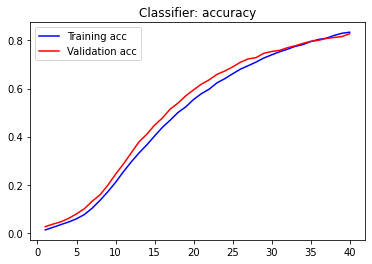

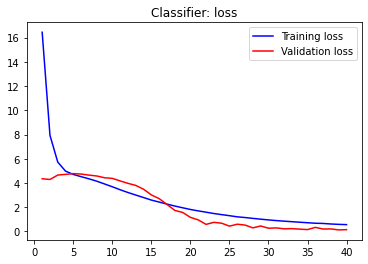

In [ ]:
# plotting performance

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'blue', label='Training acc')
plt.plot(epochs, val_acc, 'red', label='Validation acc')
plt.title('Classifier: accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'blue', label='Training loss')
plt.plot(epochs, val_loss, 'red', label='Validation loss')
plt.title('Classifier: loss')
plt.legend()

plt.show()

In [ ]:
val_gen.reset()
loss_v, accuracy_v = model.evaluate(val_gen, steps=(val_gen.n / batch_size) + 1, verbose=1)
loss, accuracy = model.evaluate(test_gen, steps=(test_gen.n / batch_size) + 1, verbose=1)
print("[INFO] Validation: accuracy = %f  ;  loss_v = %f" % (accuracy_v, loss_v))
print("[INFO] Test: accuracy = %f  ;  loss_v = %f" % (accuracy, loss))

179/178 [==============================] - 18s 99ms/step
[INFO] Validation: accuracy = 0.824253  ;  loss_v = 0.123588
[INFO] Test: accuracy = 0.835861  ;  loss_v = 0.079405


[INFO] running predictions for classifier model...

178/178 [==============================] - 17s 96ms/step


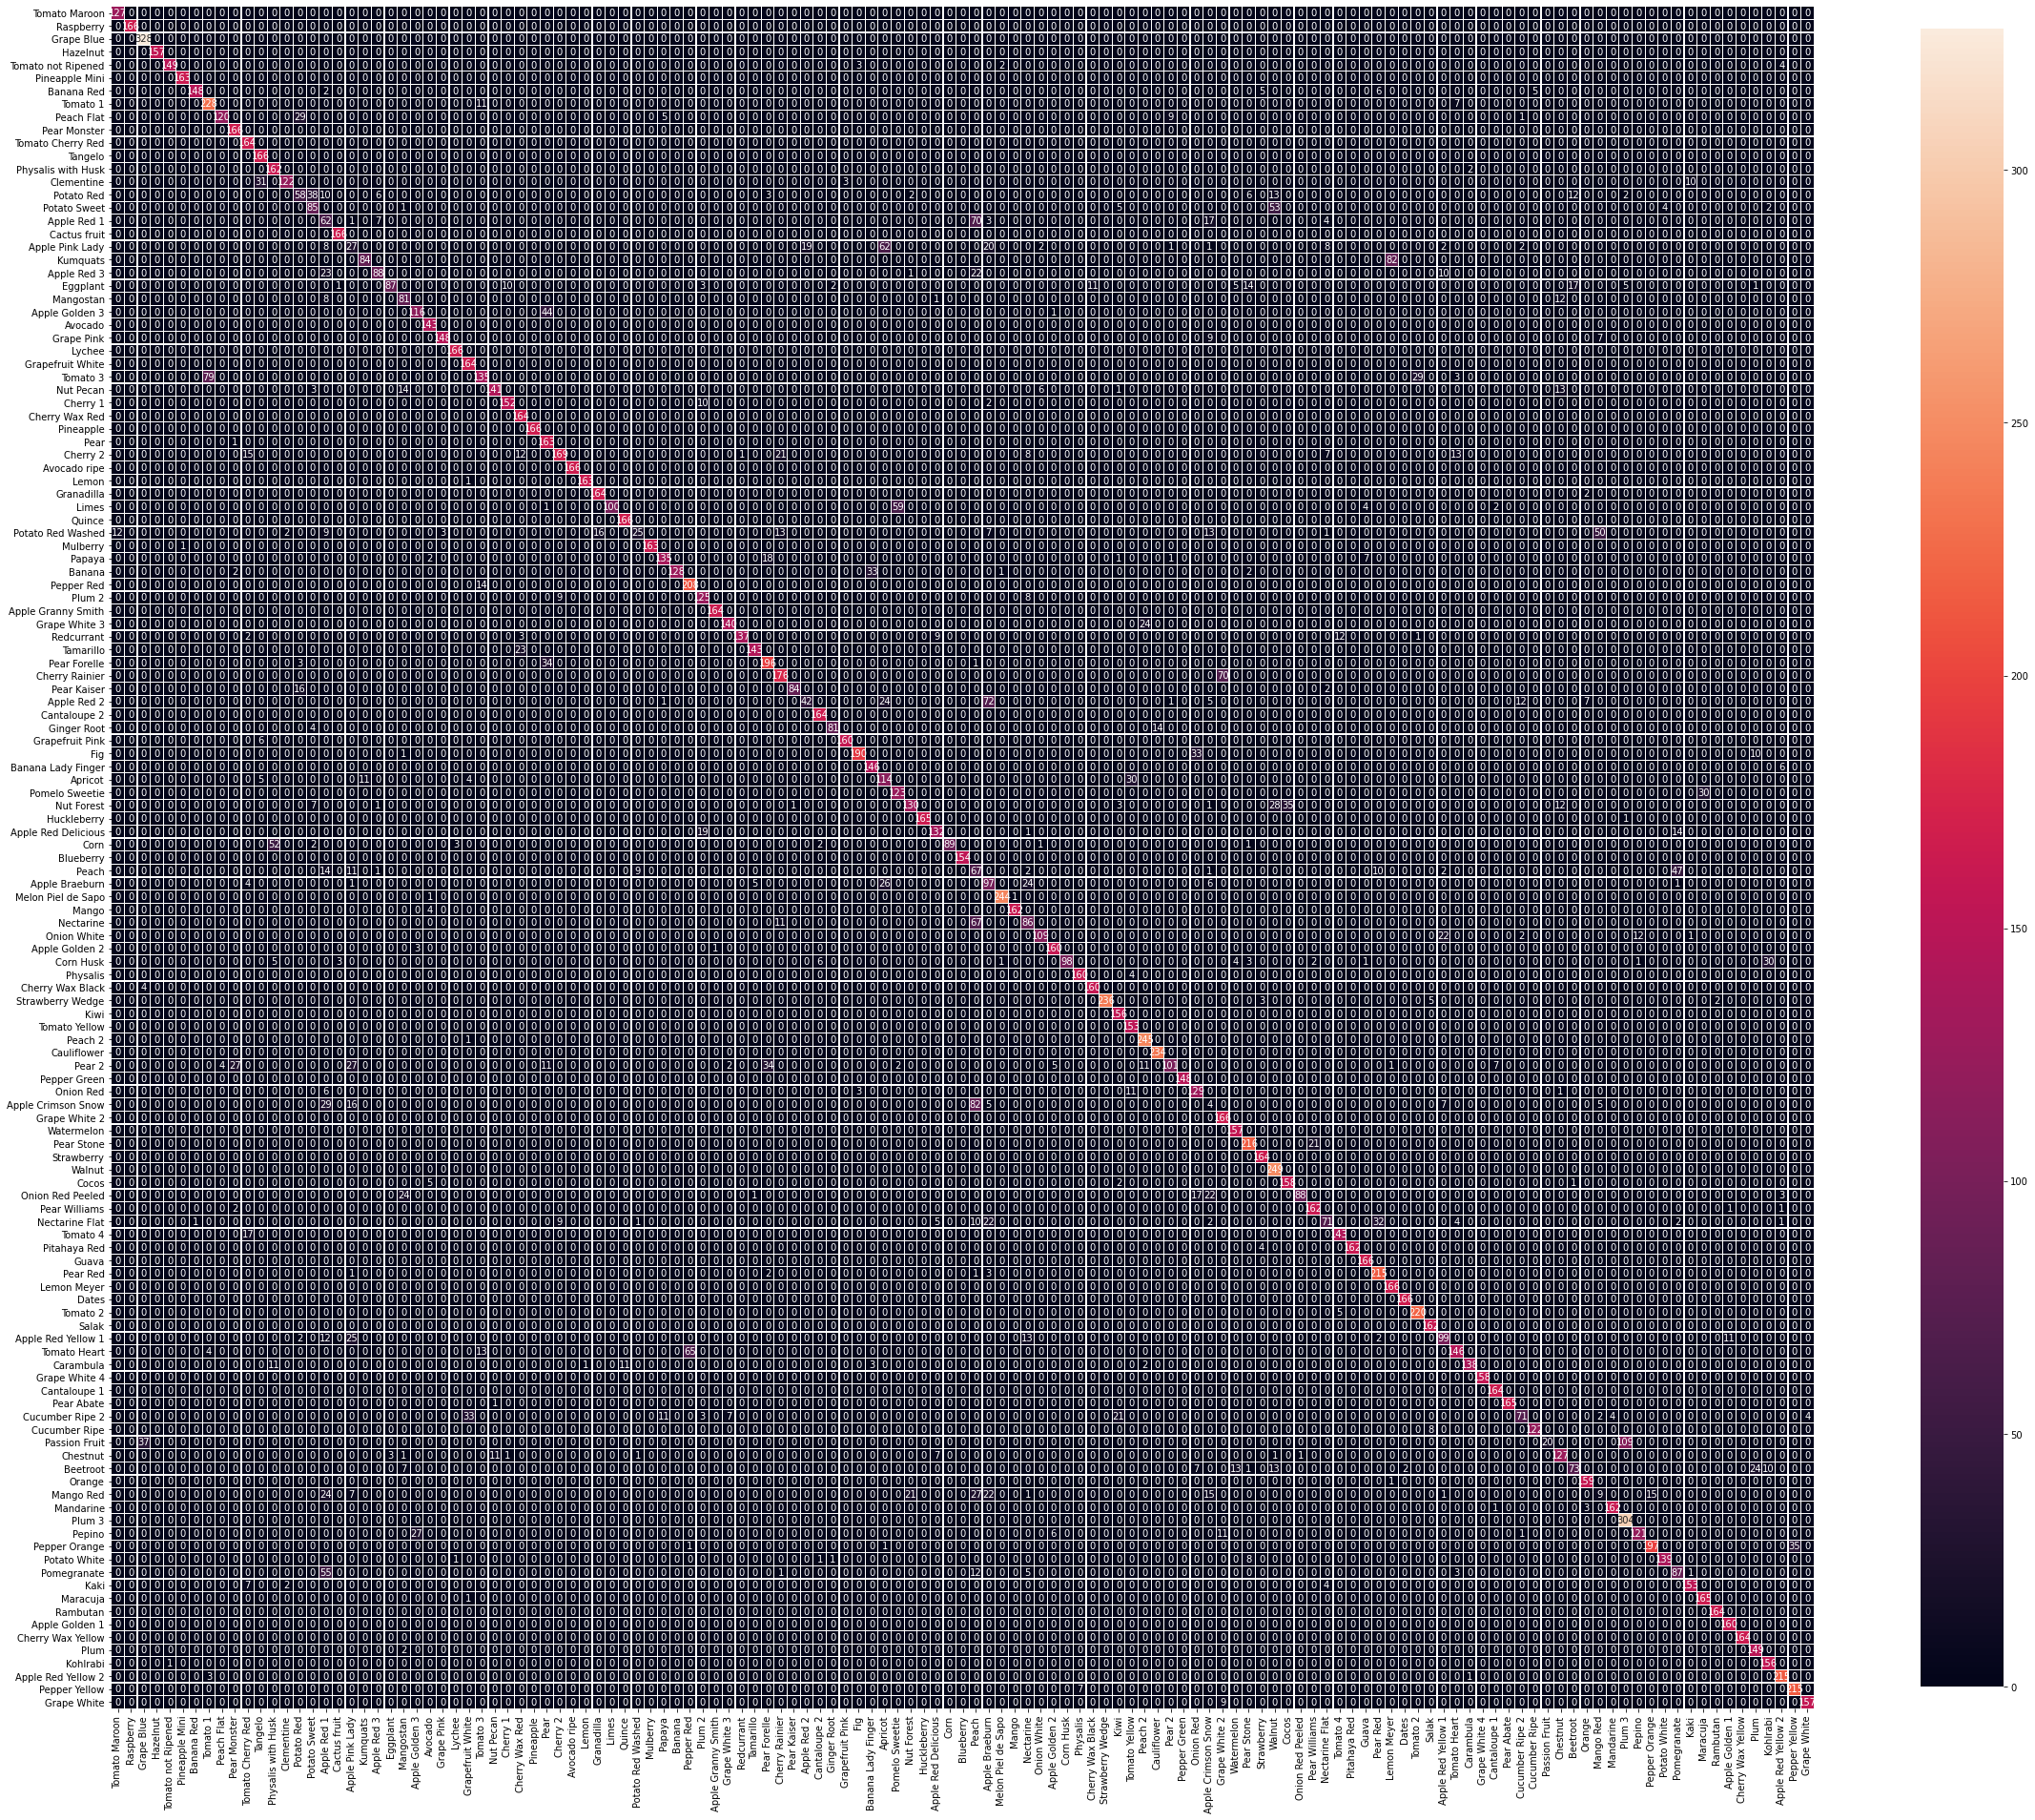

In [ ]:
#running predictions
print('[INFO] running predictions for classifier model...\n')

y_pred = model.predict(test_gen, steps=(test_gen.n // batch_size) + 1, verbose=1)
y_true = test_gen.classes[test_gen.index_array]
plot_confusion_matrix(y_true, y_pred.argmax(axis=-1), labels, out_path=(output_dir+ "/base_confusion_matrix.png"))
class_report = classification_report(y_true, y_pred.argmax(axis=-1), target_names=labels)

In [ ]:
print('[INFO] locating output directory...')
BASE_PATH = os.path.sep.join(["output_files", "base_weights.h5"])
print('[INFO] classifier weights have been stored!')
model.save(BASE_PATH)

[INFO] locating output directory...
[INFO] classifier weights have been stored!


##7.Fine Tuning

* Here, the model will consist of a unfreezing a few layers from the pretrained model, in this case VGG16, to allow the base to become more in tune with the data at hand for the given project. This is to the pretrained model already has its own weights and training them on new data with a custom classifier will destroy the weights that the base model was trained on. 

###Model Structure

In [ ]:
# FT model
top_model= models.Sequential()
top_model.add(conv_base)
top_model.add(layers.Dropout(0.4))
top_model.add(layers.Flatten())  # this converts our 3D feature maps to 1D feature vectors
top_model.add(layers.Dense(256, activation='relu', name='fc_1'))
top_model.add(layers.Dense(128, activation='relu', name='fc_2'))
top_model.add(layers.Dense(len(labels), activation = "softmax", name='predictions'))

print('[INFO] classifier model loaded!')

[INFO] classifier model loaded!


In [ ]:
print('[INFO] loading classifier weights...')
top_model.load_weights('/content/output_files/base_weights.h5')
print('[INFO] classifier weights loaded!')

[INFO] loading classifier weights...
[INFO] classifier weights loaded!


In [ ]:
# checking the amount of trainable parameter in the frozen model
top_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Model)                (None, 3, 3, 512)         20024384  
_________________________________________________________________
dropout_2 (Dropout)          (None, 3, 3, 512)         0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 4608)              0         
_________________________________________________________________
fc_1 (Dense)                 (None, 256)               1179904   
_________________________________________________________________
fc_2 (Dense)                 (None, 128)               32896     
_________________________________________________________________
predictions (Dense)          (None, 131)               16899     
Total params: 21,254,083
Trainable params: 1,229,699
Non-trainable params: 20,024,384
__________________________________

In [ ]:
# unfreezing base
conv_base.trainable = True

In [ ]:
# reset our data generators
train_gen.reset()
val_gen.reset()

# now that the head FC layers have been trained/initialized,
# unfreeze the final block of CONV layers and making them trainable
for layer in conv_base.layers[:10]:
	layer.trainable = False
# loop over the layers in the model and show their trainable status
for layer in conv_base.layers:
	print("{}: {}".format(layer, layer.trainable))

<keras.engine.input_layer.InputLayer object at 0x7febb7c82f98>: False
<keras.layers.convolutional.Conv2D object at 0x7febb7c92cf8>: False
<keras.layers.convolutional.Conv2D object at 0x7febb7c92208>: False
<keras.layers.pooling.MaxPooling2D object at 0x7febb7c92be0>: False
<keras.layers.convolutional.Conv2D object at 0x7febb7c3e208>: False
<keras.layers.convolutional.Conv2D object at 0x7febb7c3e6d8>: False
<keras.layers.pooling.MaxPooling2D object at 0x7feb46204ac8>: False
<keras.layers.convolutional.Conv2D object at 0x7feb46204908>: False
<keras.layers.convolutional.Conv2D object at 0x7feb462065f8>: False
<keras.layers.convolutional.Conv2D object at 0x7feb46206f28>: False
<keras.layers.convolutional.Conv2D object at 0x7feb46207c18>: True
<keras.layers.pooling.MaxPooling2D object at 0x7feb4620a6a0>: True
<keras.layers.convolutional.Conv2D object at 0x7feb4620a4e0>: True
<keras.layers.convolutional.Conv2D object at 0x7feb4620afd0>: True
<keras.layers.convolutional.Conv2D object at 0x7fe

In [ ]:
# checking the amount of trainable parameters in the unfrozen model.
top_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Model)                (None, 3, 3, 512)         20024384  
_________________________________________________________________
dropout_2 (Dropout)          (None, 3, 3, 512)         0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 4608)              0         
_________________________________________________________________
fc_1 (Dense)                 (None, 256)               1179904   
_________________________________________________________________
fc_2 (Dense)                 (None, 128)               32896     
_________________________________________________________________
predictions (Dense)          (None, 131)               16899     
Total params: 21,254,083
Trainable params: 19,518,595
Non-trainable params: 1,735,488
__________________________________

In [ ]:
# compiling the model
print("[INFO] recompiling model...")
top_model.compile(loss='sparse_categorical_crossentropy',
              optimizer=opt,
              metrics=['acc'])

[INFO] recompiling model...


###Training Model (Fine Tuned)

In [ ]:
# training the model
print("[INFO] training FT model...")
start = datetime.datetime.now()

history = top_model.fit_generator(
      train_gen,
      steps_per_epoch=(len(train_gen.filenames) // batch_size) + 1,
      epochs=trained_epochs,
      validation_data=val_gen,
      validation_steps=(len(val_gen.filenames) // batch_size) + 1,
      verbose=1)

end = datetime.datetime.now()
elapsed1 = end-start

[INFO] training FT model...
Epoch 1/2
371/371 [==============================] - 183s 494ms/step - loss: 0.2546 - acc: 0.9229 - val_loss: 0.0078 - val_acc: 0.9360
Epoch 2/2
371/371 [==============================] - 180s 485ms/step - loss: 0.0678 - acc: 0.9785 - val_loss: 5.7626e-04 - val_acc: 0.9419


###Visualising Results

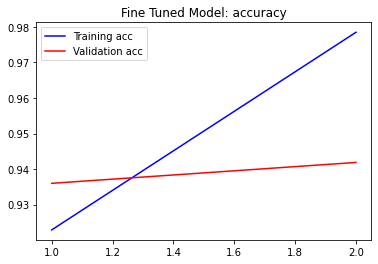

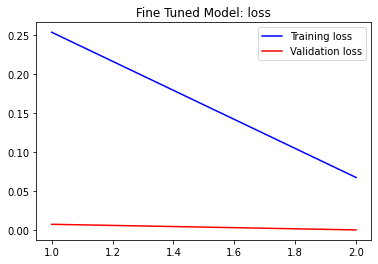

In [ ]:
# plotting performance

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'blue', label='Training acc')
plt.plot(epochs, val_acc, 'red', label='Validation acc')
plt.title('Fine Tuned Model: accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'blue', label='Training loss')
plt.plot(epochs, val_loss, 'red', label='Validation loss')
plt.title('Fine Tuned Model: loss')
plt.legend()

plt.show()

In [ ]:
val_gen.reset()
loss_v, accuracy_v = top_model.evaluate(val_gen, steps=(val_gen.n / batch_size), verbose=1)
loss, accuracy = top_model.evaluate(test_gen, steps=(test_gen.n / batch_size), verbose=1)
print("[INFO] Validation: accuracy = %f  ;  loss_v = %f" % (accuracy_v, loss_v))
print("[INFO] Test: accuracy = %f  ;  loss_v = %f" % (accuracy, loss))

178/177 [==============================] - 17s 96ms/step
[INFO] Validation: accuracy = 0.940883  ;  loss_v = 0.000372
[INFO] Test: accuracy = 0.948651  ;  loss_v = 0.000342


[INFO] running predictions for classifier model...

178/178 [==============================] - 17s 95ms/step


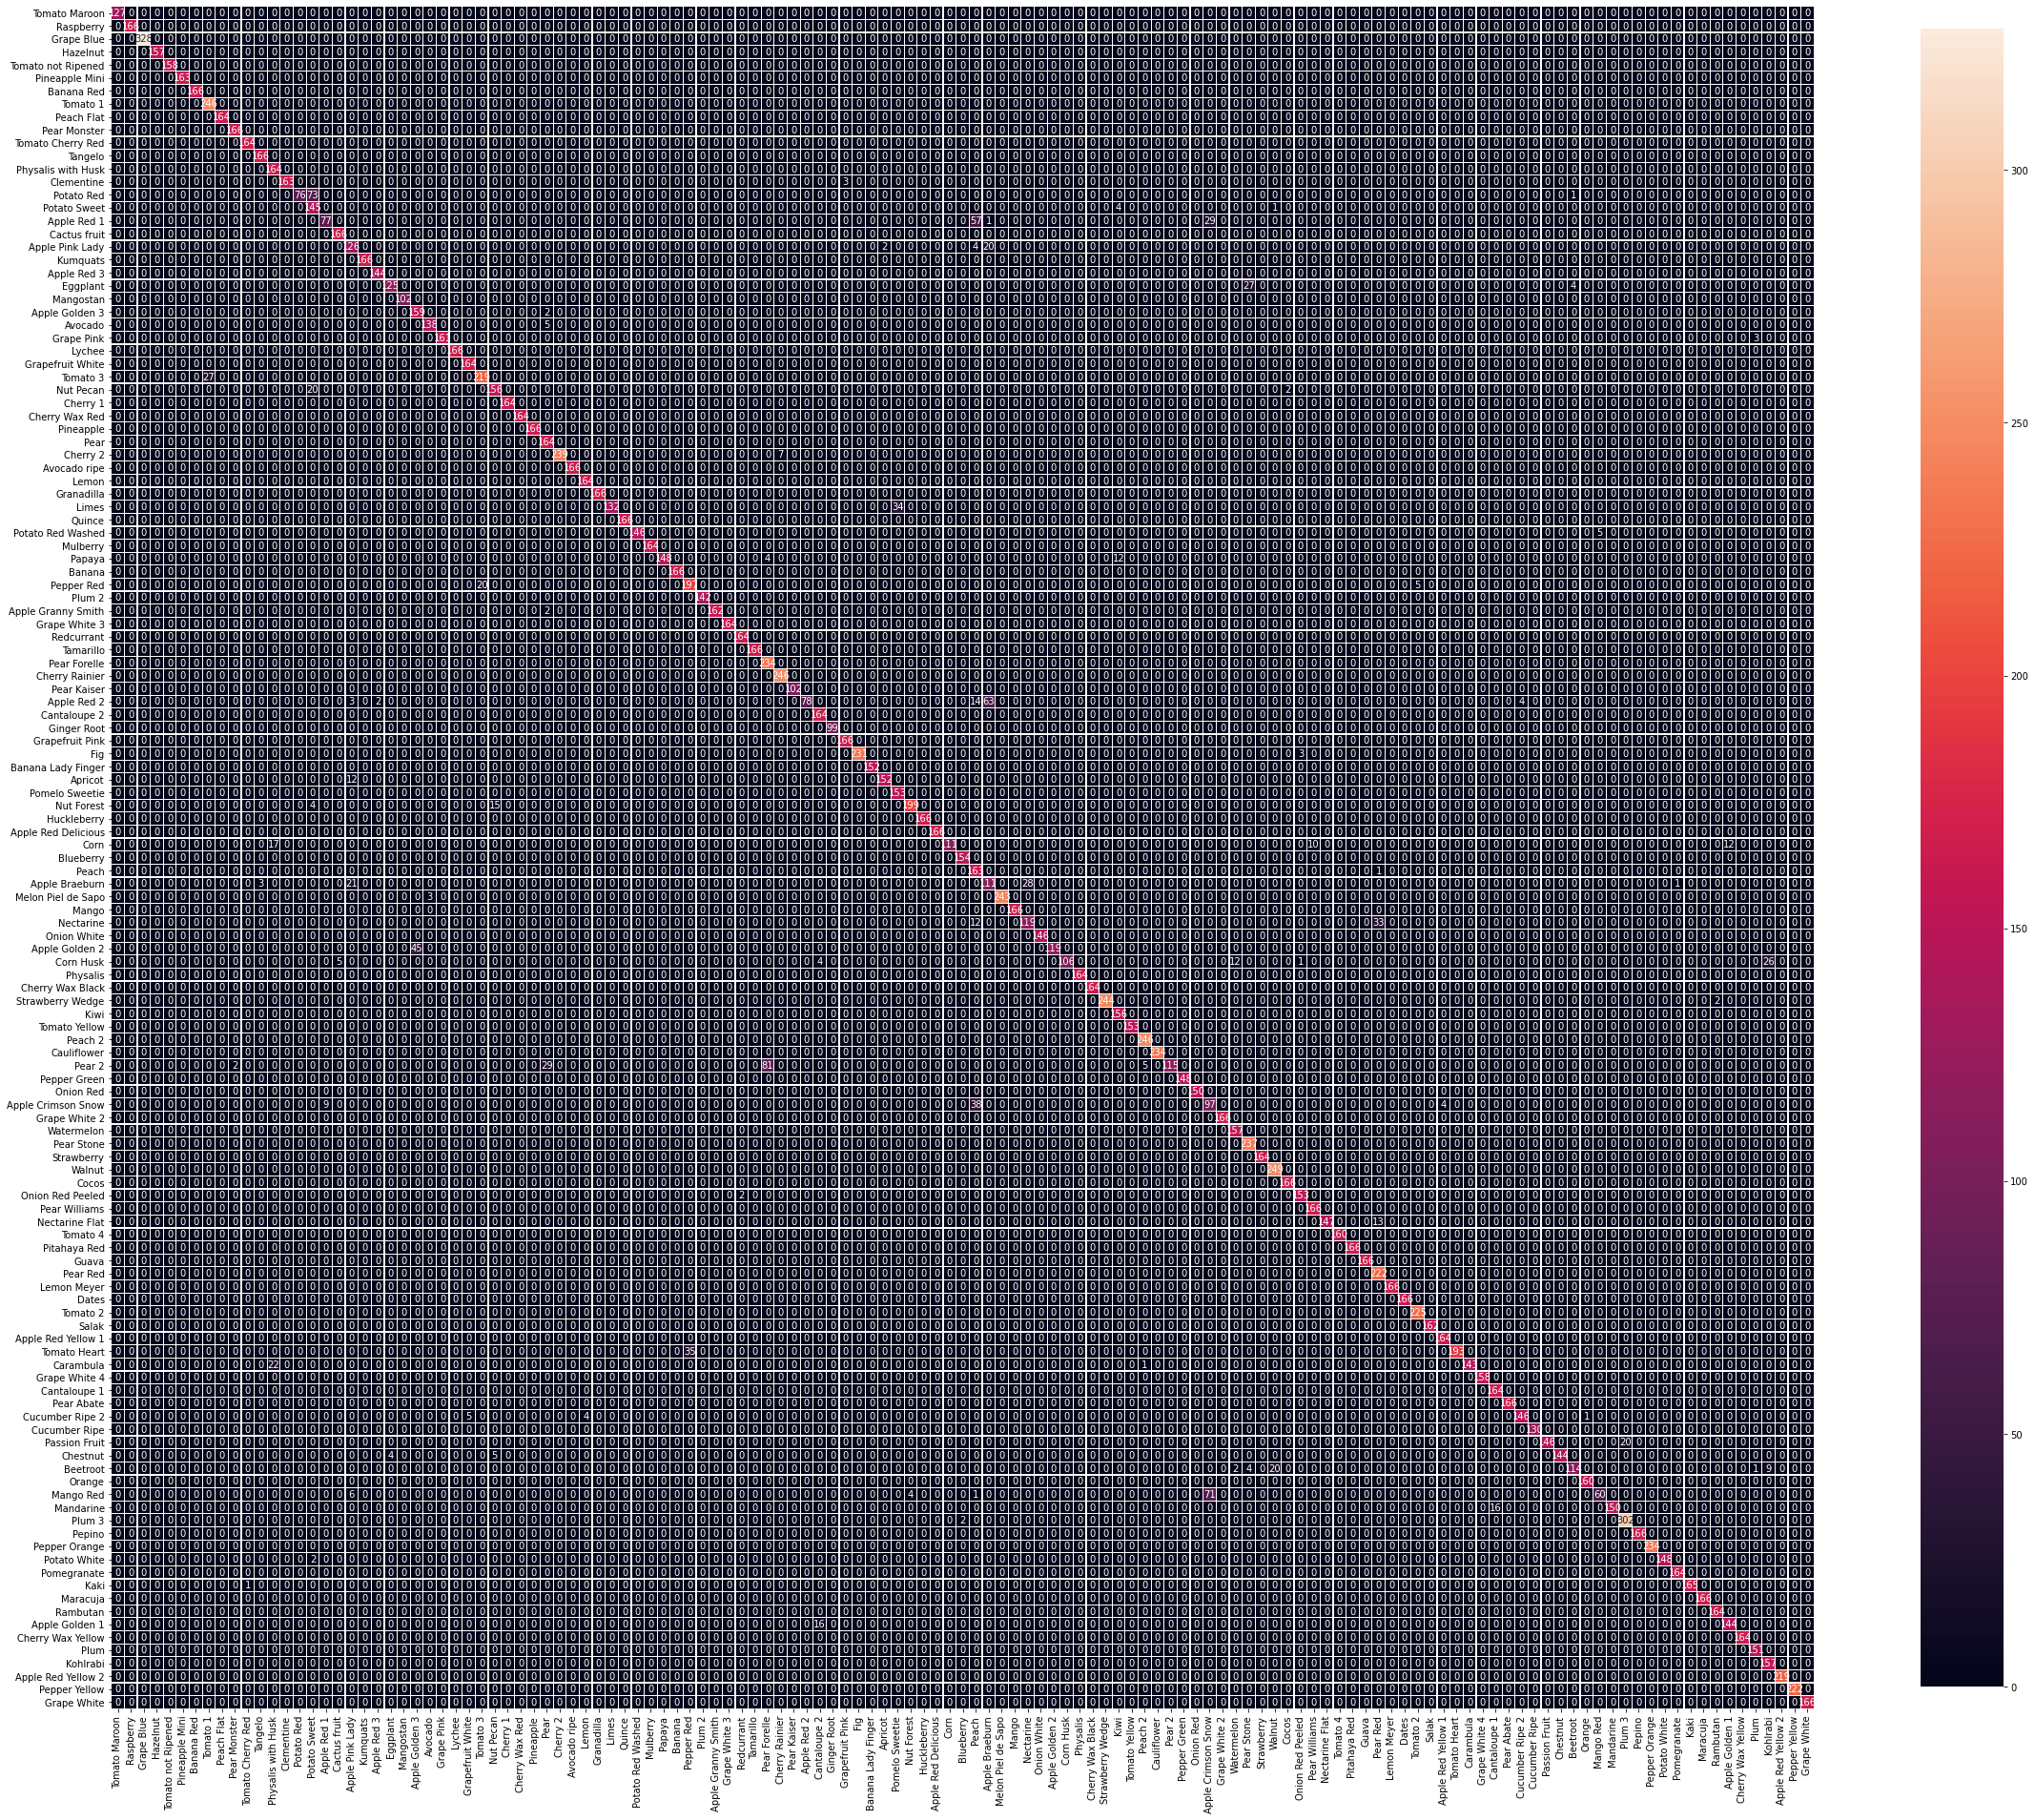

In [ ]:
#running predictions
print('[INFO] running predictions for classifier model...\n')

y_pred = top_model.predict(test_gen, steps=(test_gen.n // batch_size) + 1, verbose=1)
y_true = test_gen.classes[test_gen.index_array]
plot_confusion_matrix(y_true, y_pred.argmax(axis=-1), labels, out_path=(output_dir+ "/ft_confusion_matrix.png"))
class_report = classification_report(y_true, y_pred.argmax(axis=-1), target_names=labels)

In [ ]:
# printing training durations for each phase and total duration
print('[INFO] Training Model Duration: ', elapsed1)
total = elapsed+elapsed1
print('[INFO] Total Training Duration: ', total)

[INFO] Training Model Duration:  0:06:04.051788
[INFO] Total Training Duration:  2:01:35.811771


In [ ]:
print('[INFO] locating output directory...')
TOP_PATH = os.path.sep.join(["output_files", "final_weights.h5"])
print('[INFO] final model weights have been stored!')
top_model.save(TOP_PATH)

[INFO] locating output directory...
[INFO] final model weights have been stored!
